In [7]:
## This program was written using google colab, these libraries allow file imports and streamline some features
import os
from google.colab import drive
drive.mount('/content/drive')

## The Dataframe and Math libraries

import pandas as pd
import numpy as np

## And a lot of plotting Libraries

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import transforms
from matplotlib.patches import Circle, PathPatch
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib as mpl

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
##This section of the code loaded all our data provided from SMT from our google drive into a single nested dataframe

pd.set_option('display.width', 180)
base_folder_path = '/content/drive/MyDrive/smt_data_challenge_2023/'
subfolders = ['ball_pos', 'player_pos', 'game_events', 'game_info']

bbdata = {}

for subfolder in subfolders:
    folder_path = os.path.join(base_folder_path, subfolder)
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

    for csv_file in csv_files:
        file_name = os.path.splitext(csv_file)[0]
        file_path = os.path.join(folder_path, csv_file)
        bbdata[file_name] = pd.read_csv(file_path)

##This is where the data starts being parsed to find out POI's
##Here we look for only plays where a catcher makes a throw and start to find our POI's

filtered_play_game_combinations = []

for key, df in bbdata.items():
    if key.startswith('game_events'):
        filtered_indices = df.index[(df['player_position'] == 2) & (df['event_code'] == 3)]
        for index in filtered_indices:
            play_id = df.loc[index, 'play_id']
            game_str = df.loc[index, 'game_str']
            filtered_play_game_combinations.append((game_str, play_id))


unique_filtered_play_game_combinations = list(set(filtered_play_game_combinations))

##This saves all our plays with those parameters

filtered_dfs = {}
for key, df in bbdata.items():
    if key.startswith('game_events'):
        filtered_dfs[key] = df[
            df.apply(lambda row: (row['game_str'], row['play_id']) in unique_filtered_play_game_combinations, axis=1)
        ]

# Concatenate the filtered DataFrames into a single DataFrame
concatenated_df = pd.concat(filtered_dfs.values())

grouped_df = concatenated_df.groupby(['game_str', 'play_id']).apply(lambda x: x.reset_index(drop=True))
grouped_df = grouped_df.reset_index(drop=True)

# This our next point of parsing where all instances of a steal attempt at second would show up, so limiting next player interacting to second baseman
# short stops, and actions like ball bounces or deflections, including deflections off runners
filtered_groups = []
for (game_str, play_id), group_df in grouped_df.groupby(['game_str', 'play_id']):
    if game_str > "1901_18_TeamLH_TeamA3":
        if (group_df['player_position'].iloc[0] == 1) & (group_df['event_code'].iloc[0] == 1):
            if any(
                (group_df['player_position'].isin([4, 6, 11, 12, 255])) &
                (group_df['event_code'].isin([2, 9, 16]))
            ):
                if not (
                    (group_df['player_position'].shift(-1) == 255) &
                    (group_df['event_code'].shift(-1) == 16) &
                    (group_df['player_position'] == 3)
                ).any():
                    if not (
                        (group_df['player_position'].shift(-1) == 255) &
                        (group_df['event_code'].shift(-1) == 16) &
                        (group_df['player_position'] == 5)
                    ).any():
                        if not (
                            (group_df['player_position'] == 10) &
                            (group_df['event_code'] == 4)
                        ).any():
                            filtered_groups.append(group_df)

filtered_grouped_df = pd.concat(filtered_groups)

# Counting the number of unique combinations of game_str and play_id these qualify as our POI's
num_unique_combinations = filtered_grouped_df[['game_str', 'play_id']].drop_duplicates().shape[0]

# checking number of POI's
print("Number of unique combinations:", num_unique_combinations)

# Saving the filtered data to a CSV, if you run this code yourself, change the location of saved file
filtered_grouped_df.to_csv('/content/drive/MyDrive/smt_data_challenge_2023/PossibleStealAttempts.csv', index=False)

Number of unique combinations: 106


In [77]:
# Read the Steals.csv file to plot positions of our players during unsuccessful caught stealing attempts
steals = pd.read_csv('/content/drive/MyDrive/smt_data_challenge_2023/Steals.csv')

# Drop our notes from CSV
game_play_list = steals[['game_str', 'play_id']].drop_duplicates().values.tolist()

game_play_df = pd.DataFrame(game_play_list, columns=['game_str', 'play_id'])

# Initialize an empty list to store the filtered DataFrames
filtered_dataframes = []

# Iterate through the keys in bbdata to find the timestamp of the play when it start
for key, df in bbdata.items():
    # Check if the key starts with 'game_events'
    if key.startswith('game_events'):
        # Filter rows where player_position is 1 and event_code is 1 (start of play)
        filtered_rows = df[(df['player_position'] == 1) & (df['event_code'] == 1)]

        filtered_dataframes.append(filtered_rows)


filtered_game_events_df = pd.concat(filtered_dataframes)

merged_df = pd.merge(game_play_df, filtered_game_events_df, on=['game_str', 'play_id'])

merged_df = merged_df[['game_str', 'timestamp']]

position_dataframes = []

for key, df in bbdata.items():
    # Check if the key starts with 'player_pos'
    if key.startswith('player_pos'):
        # Filter rows where player_position is second or short
        filtered_rows = df[df['player_position'].isin([4, 6])]
        # Append the filtered rows to the list
        position_dataframes.append(filtered_rows)


filtered_player_pos_df = pd.concat(position_dataframes)

steals_pos_df = pd.merge(merged_df, filtered_player_pos_df, on=['game_str', 'timestamp'])
steals_pos_df = steals_pos_df.drop(columns=['Unnamed: 0'])

# Calculate plot_x and plot_y columns (this is a scale we made for our plot)
steals_pos_df['plot_x'] = steals_pos_df['field_x'] * (.31 / 90)
steals_pos_df['plot_y'] = steals_pos_df['field_y'] * (.31 / 90)

steals_pos_df.to_csv('/content/drive/MyDrive/smt_data_challenge_2023/PlotSteals.csv', index=False)

##Now we just do the same thing with our parsed caught stealing data but this time only grabbing the player position of the player who caught the runner

caught_steals = pd.read_csv('/content/drive/MyDrive/smt_data_challenge_2023/CaughtStealing.csv')

# drop catcher data from this set
caught_steals_modified = caught_steals.groupby('play_id').nth(1).reset_index()


filtered_dataframes = []

for key, df in bbdata.items():
    if key.startswith('game_events'):
        filtered_rows = df[(df['player_position'] == 1) & (df['event_code'] == 1)]
        filtered_dataframes.append(filtered_rows)

filtered_game_events_df = pd.concat(filtered_dataframes)

# Merge to get game_str and timestamp
merged_df = pd.merge(caught_steals_modified[['game_str', 'play_id']], filtered_game_events_df, on=['game_str', 'play_id'])
merged_df = merged_df[['game_str', 'timestamp']]

# Filter player_pos DataFrames based on game_str and play_id from caught_steals_modified, this got a little more complicated since we only wanted the positioning of the player who tagged the runner
position_dataframes = []

for key, df in bbdata.items():
    if key.startswith('player_pos'):
        filtered_rows = df[df['game_str'].isin(caught_steals_modified['game_str']) & df['play_id'].isin(caught_steals_modified['play_id'])]
        filtered_rows = filtered_rows[filtered_rows['player_position'].isin(caught_steals_modified['player_position'])]
        position_dataframes.append(filtered_rows)

filtered_player_pos_df = pd.concat(position_dataframes)

caught_steals_pos_df = pd.merge(merged_df, filtered_player_pos_df, on=['game_str', 'timestamp'])
caught_steals_pos_df = caught_steals_pos_df.drop(columns=['Unnamed: 0'])


caught_steals_pos_df['plot_x'] = caught_steals_pos_df['field_x'] * (.31 / 90)
caught_steals_pos_df['plot_y'] = caught_steals_pos_df['field_y'] * (.31 / 90)


merged_cols = ['player_position', 'game_str', 'play_id']
final_df = caught_steals_pos_df.merge(caught_steals_modified, on=merged_cols)

final_df.to_csv('/content/drive/MyDrive/smt_data_challenge_2023/PlotCaughtStealing.csv', index=False)


                 game_str  timestamp_x  play_id  player_position  field_x   field_y    plot_x    plot_y  Unnamed: 0  at_bat  play_per_game  timestamp_y  event_code result  \
0   1903_31_TeamNB_TeamA1       823292       25                6 -12.9504  135.6867 -0.044607  0.467365         112       8             25       825792           2      "   
1   1902_16_TeamMD_TeamA2      1565423       49                6 -27.0381  136.2297 -0.093131  0.469236         185      14             49      1567873           2      "   
2   1902_12_TeamMI_TeamA3      1942204       61                4  24.3624  142.6614  0.083915  0.491389         232      17             61      1944504           2      "   
3   1903_30_TeamNF_TeamA2      2209197       77                4  18.3120  141.8379  0.063075  0.488553         286      19             77      2211547           2      "   
4   1902_23_TeamMA_TeamA1      2460888       80                6  14.0421  138.5706  0.048367  0.477299         299      20       

[]

<Figure size 640x480 with 0 Axes>

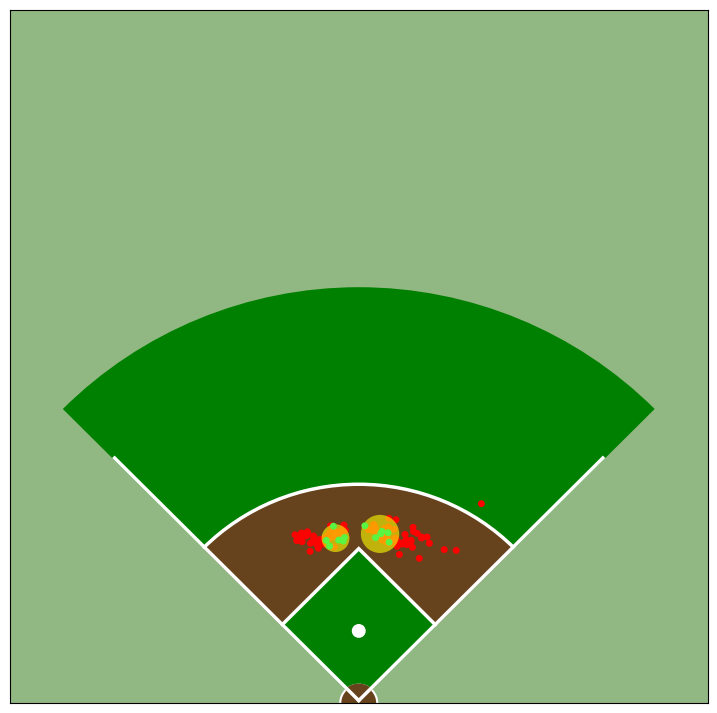

In [78]:
#loading the csv's we just made
CaughtStealing = pd.read_csv('/content/drive/MyDrive/smt_data_challenge_2023/PlotCaughtStealing.csv')
Steals = pd.read_csv('/content/drive/MyDrive/smt_data_challenge_2023/PlotSteals.csv')

#This plots our baseball field
class Baseball_Field:
    def __init__(self,figsize):
        self.figsize=figsize

    def __generate_baseball_field2D__(self):
        fig = plt.figure()
        fig, ax = plt.subplots(1, figsize=self.figsize)
        ax.add_patch(patches.Rectangle((-1.,0.0), 7, 7, facecolor="#247309",  alpha=0.50))

        ax.add_patch(patches.Wedge((0.00,0.00), 1.2, 45, 135, ec="none",edgecolor='orange',facecolor="green", linewidth=2, ))
        ax.add_patch(patches.Wedge((0.0,0.0), 0.6363, 45, 135, ec="none",edgecolor='orange',facecolor='white', linewidth=2, ))
        ax.add_patch(patches.Wedge((0.0,0.0), 0.6263, 45, 135, ec="none",edgecolor='orange',facecolor='#66431d', linewidth=2, ))

        ax.add_patch(patches.Rectangle((0.0,0.0), 0.32, 0.32, angle=45, facecolor="white",ec="none"))
        ax.add_patch(patches.Rectangle((0.0,0.0), 0.31, 0.31, angle=45, facecolor="green",ec="none"))

        ax.add_patch(patches.Circle((0.0,0.0), 0.056, angle=45, ec="none",facecolor='white',edgecolor='white',linewidth=10))

        ax.add_patch(patches.Circle((0.0,0.0), 0.05, angle=45, ec="none",facecolor='#66431d',edgecolor='white',linewidth=10))
        ax.add_patch(patches.Wedge((0.0,0.0), 0.056, 45, 135, ec="none",facecolor="#66431d" ))
        ax.add_patch(patches.Rectangle((0.0,0.0), 1.0, 0.01, angle=45, facecolor="white",ec="none"))
        ax.add_patch(patches.Rectangle((0.0,0.0), 0.01, 1, angle=45, facecolor="white",ec="none"))
        ax.add_patch(patches.Circle((0.00,0.208), 0.02, angle=45, ec="none",facecolor='white',edgecolor='white',linewidth=10))

        for indsex, row in Steals.iterrows():
            ax.add_patch(patches.Circle((row['plot_x'], row['plot_y']), .01, facecolor='#fc0303'))
            ###CENTROID PLOT###
        ax.add_patch(patches.Circle((-0.06664, 0.475687), .040, facecolor="yellow", alpha=0.6))
        ax.add_patch(patches.Circle((0.061075, 0.487966), .055, facecolor="yellow", alpha=0.6))
            ###CENTROID PLOT###
        for index, row in CaughtStealing.iterrows():
            ax.add_patch(patches.Circle((row['plot_x'], row['plot_y']), .01, facecolor='#5af542'))


        plt.grid()
        plt.xlim(-1,1)
        plt.ylim(0,2)
        return fig,ax
        obj=Baseball_Field((9,9))
        fig,ax=obj.__generate_baseball_field2D__()

obj=Baseball_Field((9,9))
fig,ax=obj.__generate_baseball_field2D__()
ax.set_xticks([])
ax.set_yticks([])

